In [14]:
import rawpy

out_of_focus = r"D:\Astro\20220430-whale\outoffocus\Image741.nef"
in_focus = r"D:\Astro\20220430-whale\light\Image752.nef"
with open(out_of_focus, "rb") as f:
  rawimg = rawpy.imread(f)
  img = rawimg.postprocess()



In [15]:
img.shape

(2868, 4310, 3)

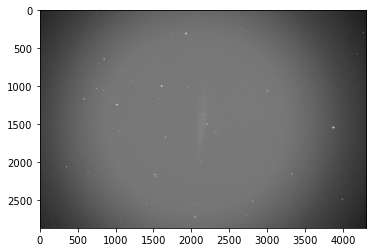

In [16]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [17]:
Bs = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(7,7))
Bmi = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
Be = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(25,25))
Bmo = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
d = (Bmo.shape[0] - Bmi.shape[0]) // 2
Bm = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
Bm[d:d+Bmi.shape[0], d:d+Bmi.shape[0]] -= Bmi


In [18]:
K = cv2.morphologyEx(gray, cv2.MORPH_OPEN, Bs)
N = cv2.morphologyEx(cv2.morphologyEx(gray, cv2.MORPH_DILATE, Bm), cv2.MORPH_ERODE, Be)
print(K.shape, N.shape)

(2868, 4310) (2868, 4310)


In [19]:
R = K -np.minimum(K,N)

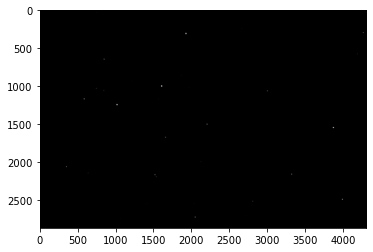

In [20]:
plt.imshow(R, cmap='gray')

In [21]:
numstars, labels, stats, centroids = cv2.connectedComponentsWithStats(R, 4, cv2.CV_16U, cv2.CCL_WU)

In [28]:
centroids

array([[2154.61204619, 1433.46232672],
       [ 749.5       ,   35.        ],
       [2658.70247934,  247.25619835],
       [2609.5       ,  250.5       ],
       [4260.50331126,  297.28476821],
       [1923.49      ,  308.10333333],
       [1733.5       ,  328.        ],
       [3803.        ,  349.        ],
       [4181.32142857,  577.33035714],
       [ 844.9       ,  645.47391304],
       [ 782.        ,  701.        ],
       [1862.61176471,  859.37647059],
       [1202.89873418,  931.91139241],
       [1603.36012862,  999.64630225],
       [1957.85      , 1019.89      ],
       [ 743.37168142, 1031.8539823 ],
       [ 840.69306931, 1058.63366337],
       [2997.54716981, 1063.03301887],
       [ 582.49193548, 1168.47177419],
       [1559.90410959, 1169.11643836],
       [1014.61290323, 1244.41935484],
       [2202.19762846, 1501.2687747 ],
       [3867.12109375, 1545.74609375],
       [1048.05147059, 1591.        ],
       [1654.        , 1674.64074074],
       [2592.57480315, 18

In [22]:
def getStar(staridx):
  centorid_x, centroid_y = centroids[staridx]
  width = stats[staridx, cv2.CC_STAT_WIDTH]
  height = stats[staridx, cv2.CC_STAT_HEIGHT]
  min_row = int(max(0, centroid_y - height))
  max_row = int(min(gray.shape[0], centroid_y + height+1))
  min_col = int(max(0, centorid_x - width))
  max_col = int(min(gray.shape[1], centorid_x + width+1))
  cell = gray[min_row:max_row, min_col:max_col]
  return cell

In [23]:
def plotStar3D(ax, star):
  xs = list(range(star.shape[1]))
  ys = list(range(star.shape[0]))
  xs, ys = np.meshgrid(xs, ys)
  X = np.arange(0, star.shape[1], 1)
  Y = np.arange(0, star.shape[0], 1)
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(xs, ys, star)

In [24]:
import scipy.optimize as opt

def twoD_GaussianScaledAmp(pos, xo, yo, sigma_x, sigma_y, amplitude, offset):
    """Function to fit, returns 2D gaussian function as 1D array"""
    x,y = pos
    xo = float(xo)
    yo = float(yo)    
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img, ax):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img = np.clip((img - bg) / (img.max() - bg),0,1)
    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), 
                               img.ravel(), p0=None, #initial_guess,
                               bounds = (
                                   (0.0, 0.0, 1, 1, 0.5, -0.1), # Lower bound
                                   (img.shape[1], img.shape[0], img.shape[1], img.shape[0], 1.5, 0.5) # Upper bound
                                )
                            )
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]

    z = offset + amp*np.exp( - (((x-xcenter)**2)/(2*sigmaX**2) + ((y-ycenter)**2)/(2*sigmaY**2)))
    ax.plot_surface(x,y,z)

    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y)



Num stars: 41
5.772091630388925 6.188749578200581
8.579255368891461 9.97146153633543
8.103517198549502 10.527158695068955


<ipython-input-25-6d3440a14e7d>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


6.935848187075551 7.564124189624297
13.830680260494951 16.553095407188962
6.9116467839628495 6.587313900729115
4.561466761304767 4.742650559955767
5.691443449780973 6.263760580207554
11.860482957853009 12.740390476570987
5.139285524969317 7.2753790680652655
12.495091648839564 12.906479851593991
4.103340577582846 7.285811723725975
14.32525832071784 15.283603845499822
13.756288657214002 14.884463227215699
11.622925468237773 11.275889009676293
11.796921574945829 11.375436132474135
11.937943405056531 10.618233648089506
12.423684392099938 12.786459653354312
13.201578799514149 13.255713447554319
16.19938555425994 15.015198164516645
12.377130364277065 12.091882750610226


<ipython-input-25-6d3440a14e7d>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


19.262171429095638 16.391932303906223
15.195848268702974 13.527491951660032
13.093596061086142 12.658920489016953
11.555348245555443 9.919772058807451
5.0978261986374545 5.171303812838309
12.197462350304475 11.853978305198602
8.221790352282115 9.878937093694125
10.350454608750807 10.22770636292377
10.682744407878923 9.089861842964433
13.170673843491008 13.01032345693501
12.175424165128774 11.484655019794827
5.233863404053553 5.488350838172697
8.8195269105118 9.080301394528256
11.00766734897482 10.624803128536954
10.434721438003566 10.557270033587415
10.819079352068503 10.295811708254929
8.874489088592748 8.398717090477959
11.710478565973306 12.935015340590915
9.256047850522132 8.72589064386943


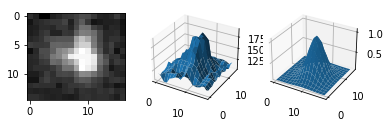

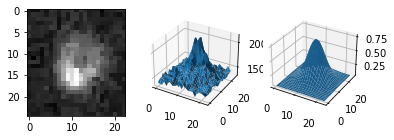

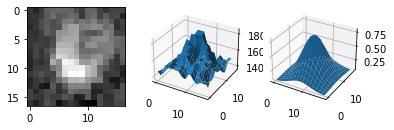

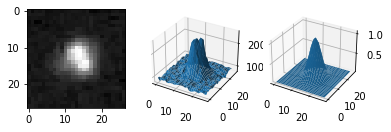

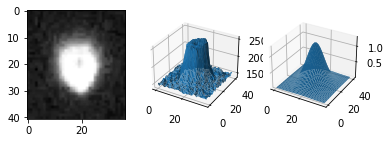

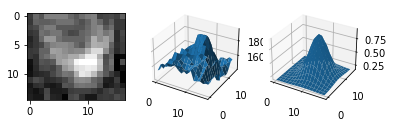

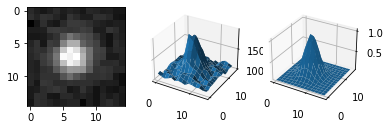

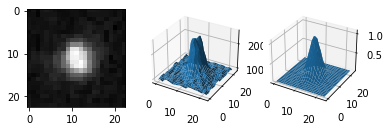

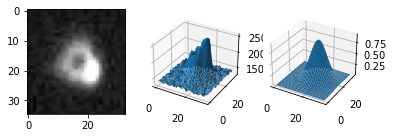

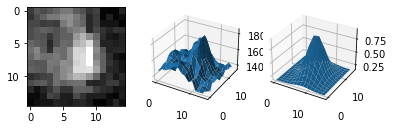

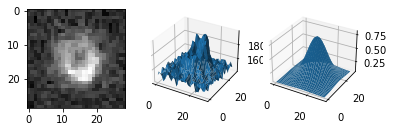

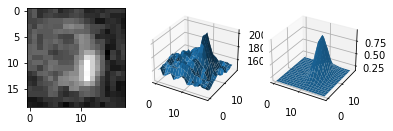

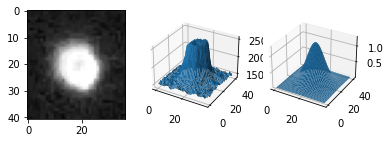

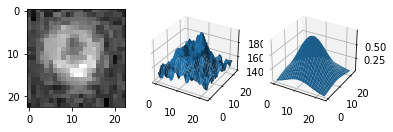

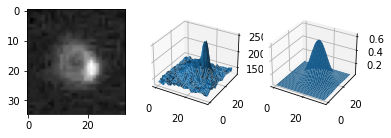

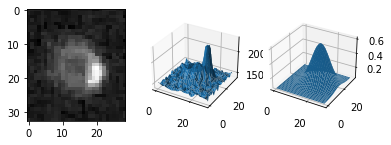

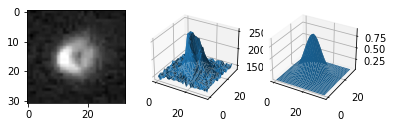

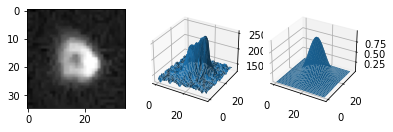

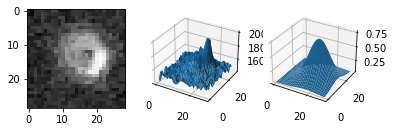

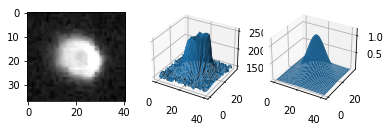

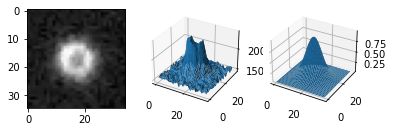

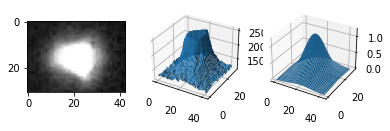

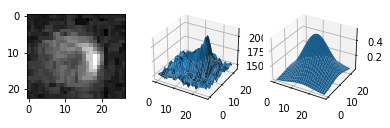

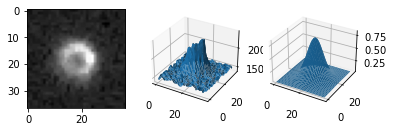

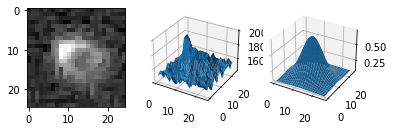

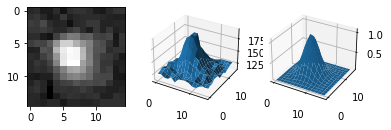

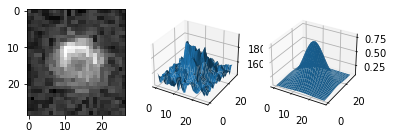

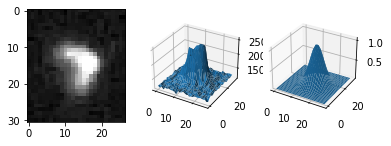

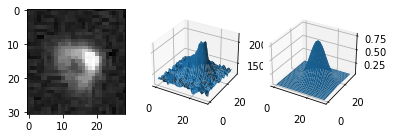

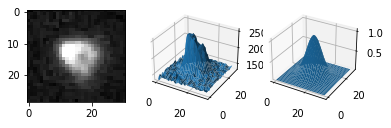

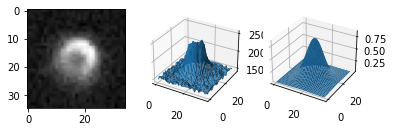

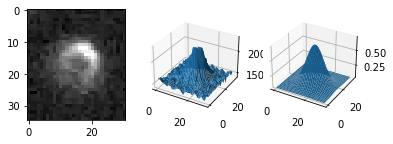

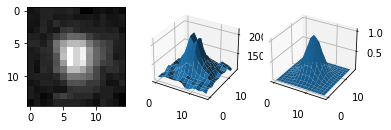

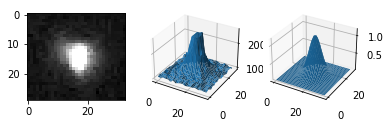

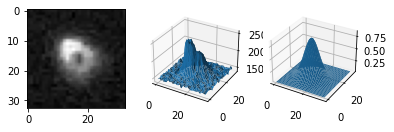

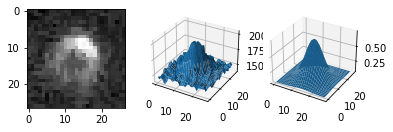

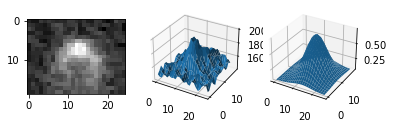

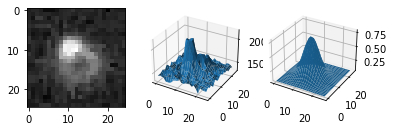

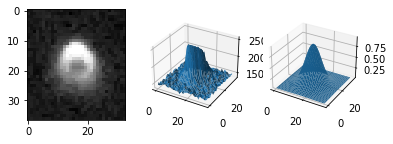

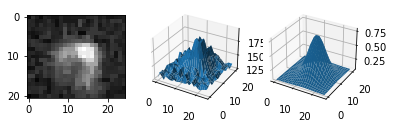

In [25]:
print(f"Num stars: {numstars}")
for staridx in range(1, numstars):
  star = getStar(staridx)

  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  ax.imshow(star, cmap='gray')

  ax = fig.add_subplot(1, 3, 2, projection='3d')
  plotStar3D(ax, star)

  ax = fig.add_subplot(1, 3, 3, projection='3d')
  FWHM_x, FWHM_y = getFWHM_GaussianFitScaledAmp(star, ax)
  print(FWHM_x, FWHM_y)
  fig.show()
  